#  Contexto
 No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.
 
 Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.
 
 Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)
 
 Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

# Objetivo
 Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.
 
 Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

# O que temos disponível, inspirações e créditos
 As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro
 -  As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
 - Os preços são dados em reais (R$)
 - Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

In [1]:
# Importando bibliotecas e a base de dados
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split


In [2]:
#Importando a base de dados
meses = {'jan':1, 'fev':2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7, 'ago':8, 'set':9, 'out':10, 'nov':11, 'dez':12}
caminho_bases = pathlib.Path('dataset_')
base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
    df['ano'] = ano
    df['mes'] = mes 
    base_airbnb = base_airbnb.append(df)
   
display(base_airbnb)

id                            listing_url       scrape_id  \
0         17878     https://www.airbnb.com/rooms/17878  20200420135919   
1         21280     https://www.airbnb.com/rooms/21280  20200420135919   
2         25026     https://www.airbnb.com/rooms/25026  20200420135919   
3         31560     https://www.airbnb.com/rooms/31560  20200420135919   
4         35636     https://www.airbnb.com/rooms/35636  20200420135919   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2020-04-22             Very Nice 2Br - Copacabana - WiFi   
1       2020-04-21              Renovated Modern Apt. Near Beach   
2       2020-04-21     Beautiful Modern Decorated Studio in Copa   
3       2020-04-21              NICE & COZY 1BDR - IPANEMA BEACH   
4       2020-04-22              Cosy flat close to Ipanema beach   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Discounts for long term stays. Pls contact me ...   
1      Immaculately renovated top-floor apartment ove...   
2      Our apartment is a little gem, everyone loves ...   
3      This nice and clean 1 bedroom apartment is loc...   
4      This cosy apartment  is just a few steps away ...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0      - large balcony which looks out on pedestrian ...   
1      Immaculately renovated top-floor apartment in ...   
2      This newly renovated studio (last renovations ...   
3      This nice and clean 1 bedroom apartment is loc...   
4      The location is extremely convenient, safe and...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Discounts for long term stays. Pls contact me ...                none   
1      Immaculately renovated top-floor apartment ove...                none   
2      Our apartment is a little gem, everyone loves ...                none   
3      This nice and clean 1 bedroom apartment is loc...                none   
4      This cosy apartment  is just a few steps away ...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

Começando os tratamentos.

 Como o dataset tem muitas colunas, o modelo pode acabar ficando muito lento.
 
Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, irei excluir algumas colunas da base
 
Tipos de colunas que será excluído:
 
IDs, Links e informações não relevantes para o modelo.

Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês.

Colunas preenchidas com texto livre -> Não rodarei nenhuma análise de palavras ou algo do tipo.

Colunas em que todos ou quase todos os valores são iguais.

Para isso, vou criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa, olhando as colunas  e identificando quais são desnecessárias


In [3]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

Após a análise qualitativa, eliminei algumas colunas de acordo com os critérios citados acima, restando as seguintes colunas:

In [4]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
display(base_airbnb)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


host_response_time host_response_rate host_is_superhost  \
0          within an hour               100%                 t   
1          within an hour               100%                 f   
2            within a day                60%                 f   
3          within an hour               100%                 t   
4          within an hour               100%                 f   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count  latitude  longitude property_type  \
0                      2.0 -22.96592  -43.17896   Condominium   
1                      0.0 -22.98467  -43.19611     Apartment   
2                      3.0 -22.97712  -43.19045     Apartment   
3                      1.0 -22.98302  -43.21427     Apartment   
4                      1.0 -22.98816  -43.19359     Apartment   
...                    ...       ...        ...           ...   
34324                  0.0 -23.00318  -43.34284     Apartment   
34325                  0.0 -22.96664  -43.39345     Apartment   
34326                 32.0 -22.96208  -43.17552     Apartment   
34327                  0.0 -23.00340  -43.34182     Apartment   
34328                  5.0 -23.01056  -43.36335     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             5        1.0  ...   
1      Entire home/apt             6        2.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             2        1.5  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                           10.0                   10.0   
1                           10.0                   10.0   
2                            9.0                    9.0   
3                           10.0                   10.0   
4                            9.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                            10.0                   10.0                 9.0   
1                            10.0                   10.0                10.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                10.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  \
0         

# Tratar colunas que estão vazias
 - Visualizando os dados, percebe-se que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN serão excluídas da análise


In [5]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() >= 100000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost            310
host_listings_count          310
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                    776
bedrooms                     458
beds                        1293
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [6]:
# Como ainda possui valores vazios, removerei as linhas que contêm valores nulos
base_airbnb = base_airbnb.dropna()
print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


In [7]:
# Verificando os tipos de dados
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           t
host_listings_count

In [16]:
#Alterando o tipo de dado da coluna "price" e "extra_people"
# price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
# extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

#verificando os tipo
print(base_airbnb.dtypes)

C:\Users\andre\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andre\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  import sys


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


# Verificando a existência de outliers
Vou basicamente olhar feature por feature para:
 
 - Ver a correlação entre as features e decidir se manterei todas as features que temos.
 - Excluir outliers (usarei como regra, valores abaixo de Q1 - 1.5 x Amplitude e valores acima de Q3 + 1.5 x Amplitude). 
 Amplitude = Q3 - Q1
 - Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
 
 
 Vou começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Essas colunas possuem valores numéricos contínuos.
 
 Depois irei analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)
 Por fim, irei avaliar as colunas de texto e definir quais categorias fazem sentido manter ou não.

<AxesSubplot:>

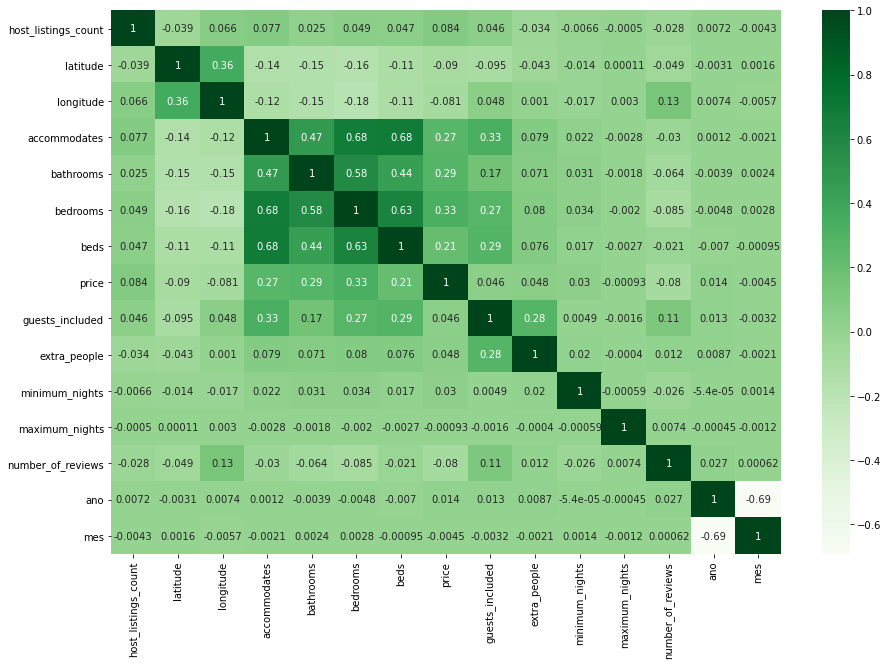

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')

# Definição de Funções para Análise de Outliers
 Irei definir algumas funções para ajudar na análise de outliers das colunas

In [12]:
def limite(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limite(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

In [13]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    fig.set_size_inches(15, 5)
    
    sns.boxplot(x=coluna, ax=ax1) 
    ax2.set_xlim(limite(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.distplot(coluna, hist=True)
    
def grafico_de_barras(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limite(coluna))
    

# Price

C:\Users\andre\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


41255, linhas removidas


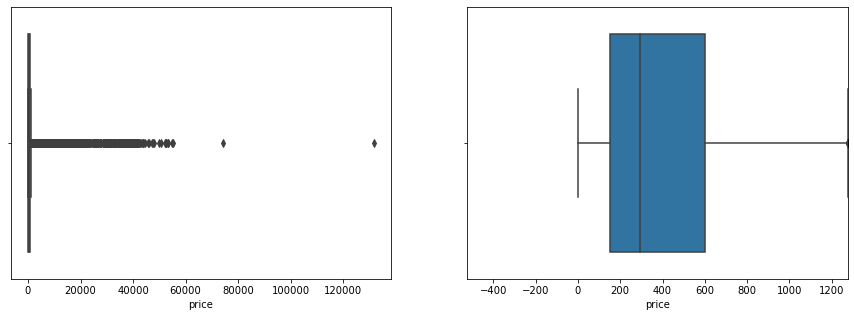

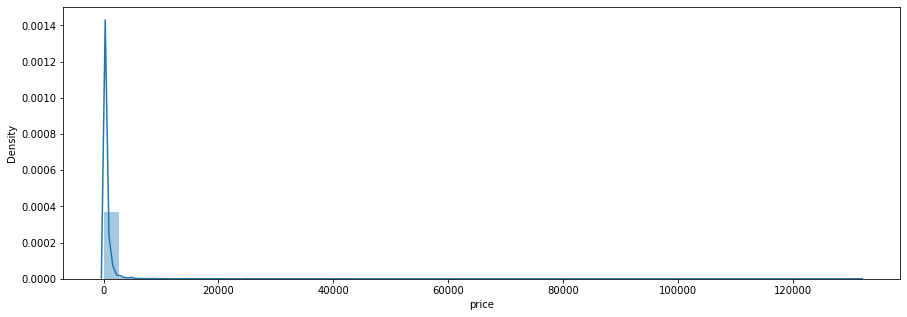

In [17]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

# Como estamos construindo um modelo para imóveis comuns, valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, irei excluir esses outliers.
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{}, linhas removidas'.format(linhas_removidas)) 

C:\Users\andre\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


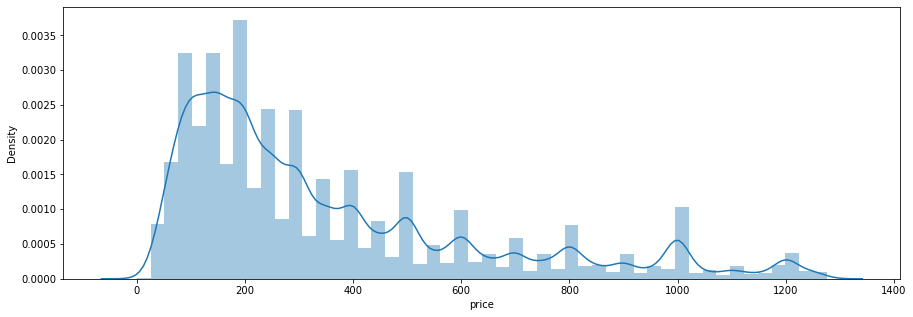

In [18]:
histograma(base_airbnb['price'])

# Extra People

C:\Users\andre\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


27912, linhas removidas


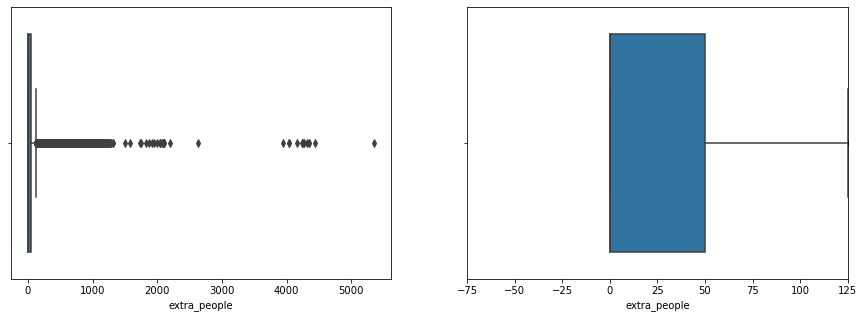

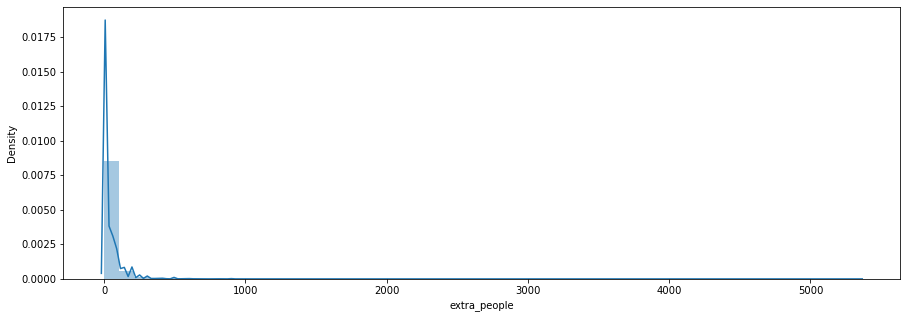

In [19]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'extra_people')
print('{}, linhas removidas'.format(linhas_removidas)) 

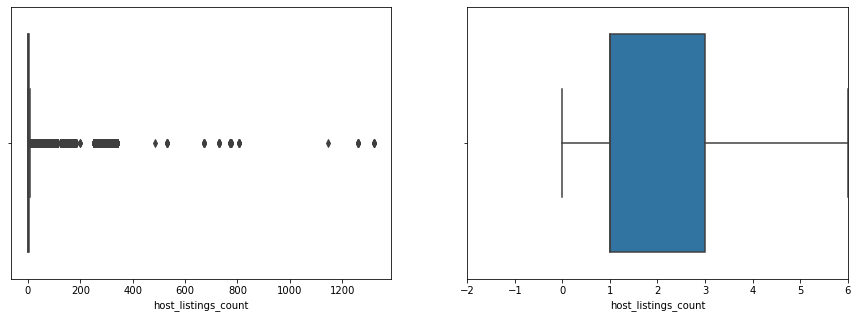

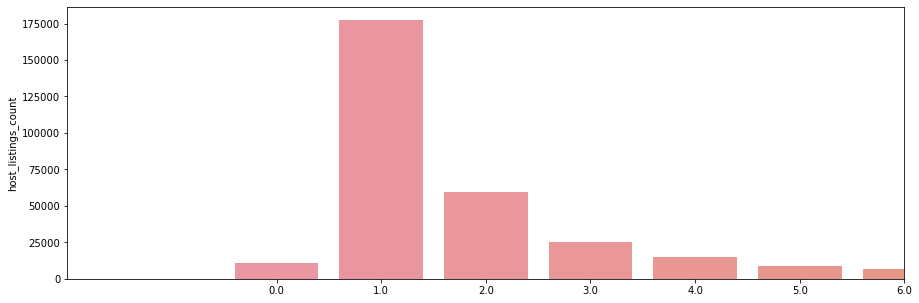

In [15]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_de_barras(base_airbnb['host_listings_count'])

# Irei excluir os outliers, pois para o objetivo do  projeto, hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [20]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{}, linhas removidas'.format(linhas_removidas))

46706, linhas removidas


# Accommodates

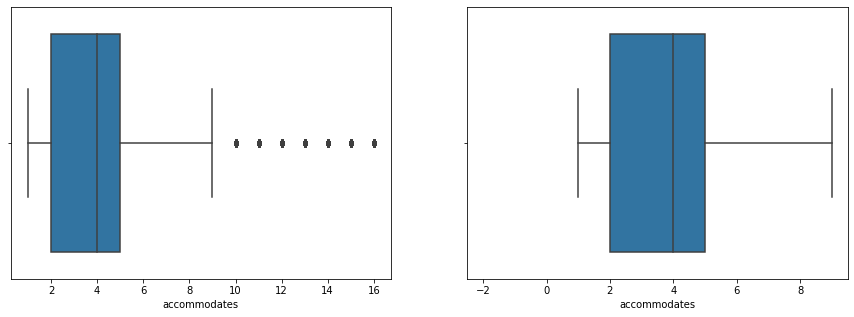

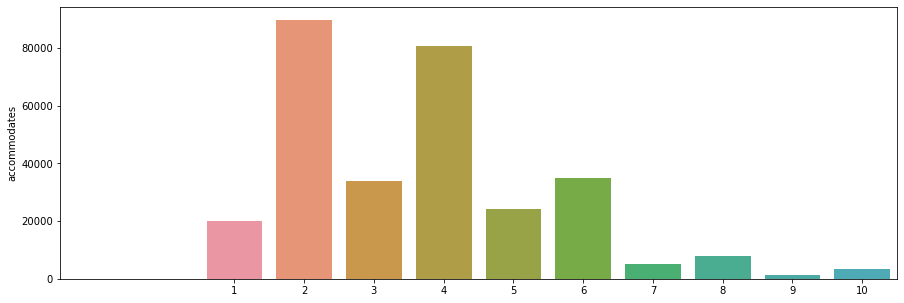

In [17]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_de_barras(base_airbnb['accommodates'])


# - Como o meu objetivo é focar em imóveis comuns, irei remover esses outliers, pois imóveis que acomodam mais de 9 pessoas, são de altíssimo nível
# - Caso fosse construir um modelo que também focasse em imóveis de altíssimo nível, seria necessário construir um outro modelo contendo esses outliers

In [21]:
base_aibrnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{}, linhas removidas'.format(linhas_removidas))

6105, linhas removidas


# Bathrooms

<AxesSubplot:ylabel='bathrooms'>

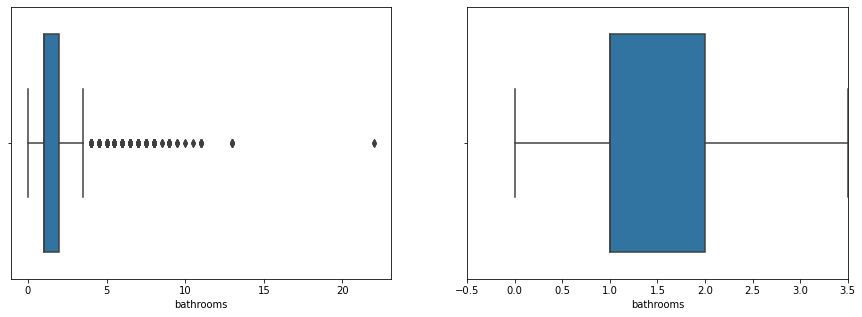

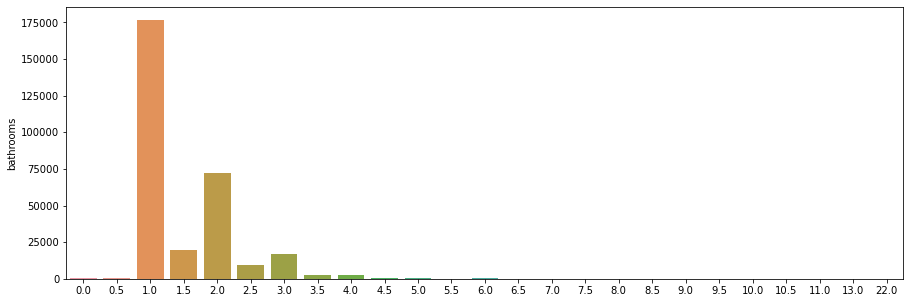

In [19]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())
# Irei excluir os outliers dos banheiros pelo mesmo motivo anterior

In [22]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{}, linhas removidas'.format(linhas_removidas))

4832, linhas removidas


# bedrooms

<AxesSubplot:ylabel='bedrooms'>

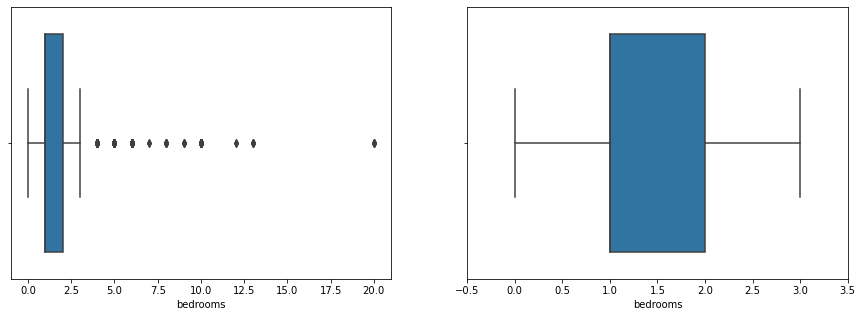

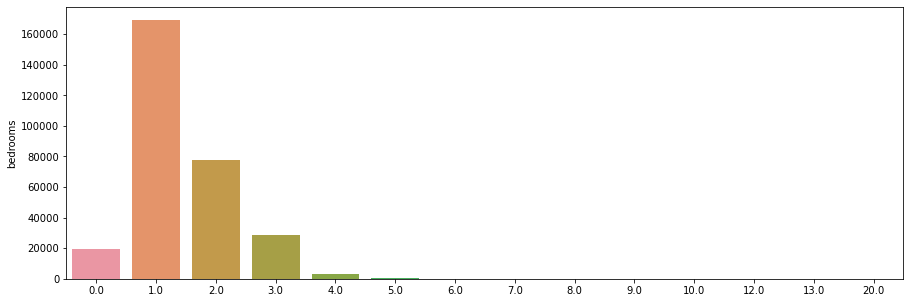

In [21]:
diagrama_caixa(base_airbnb['bedrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base_airbnb['bedrooms'].value_counts().index, y=base_airbnb['bedrooms'].value_counts())
# Também se enquadra nos mesmos requisitos citados acima para remover os outliers

In [23]:
base_airbnb, remover_linhas = excluir_outliers(base_airbnb, 'bedrooms')
print('{}, linhas removidas'.format(linhas_removidas))


4832, linhas removidas


# Beds

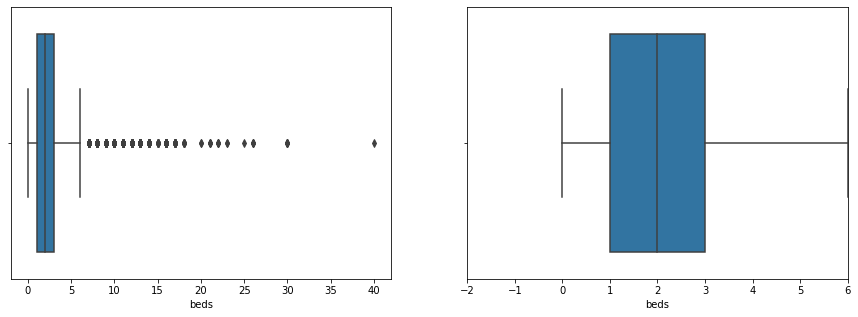

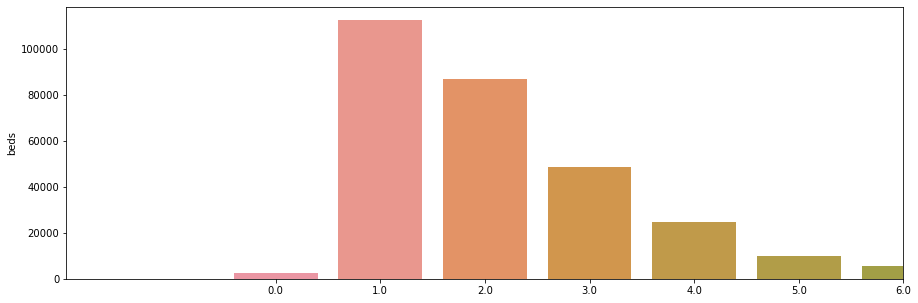

In [23]:
diagrama_caixa(base_airbnb['beds'])
grafico_de_barras(base_airbnb['beds'])


# Também se enquadra nos mesmos requisitos citados acima para remover os outliers

In [24]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{}, linhas removidas'.format(linhas_removidas))

3827, linhas removidas


# Guests_included

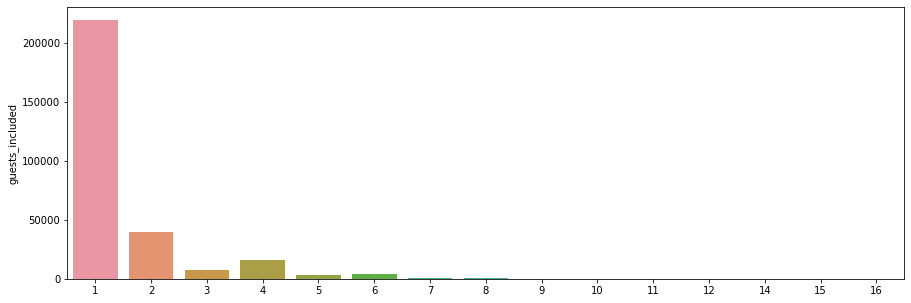

In [25]:
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())


# Irei remover essa feature da analise pois, me parece que a Airbnb usa na maioria das vezes o valor 1 como padrão para o guest included. Então para evitar que o modelo considere uma feature que não seja essencial para a construção do preço, talvez excluir essa feature da análise seja o melhor a se fazer 
base_airbnb = base_airbnb.drop('guests_included', axis=1)

# Minimum nights

19329, linhas removidas


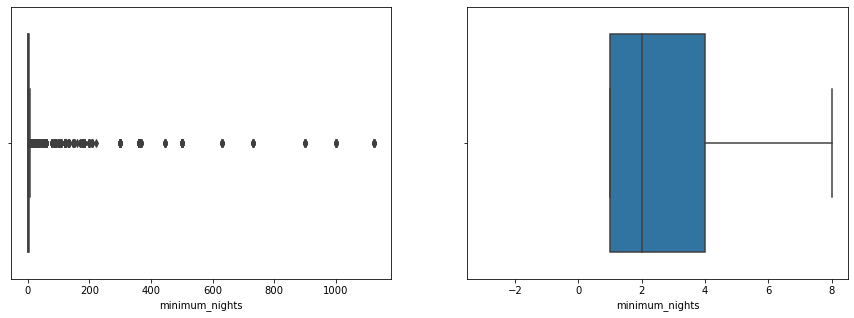

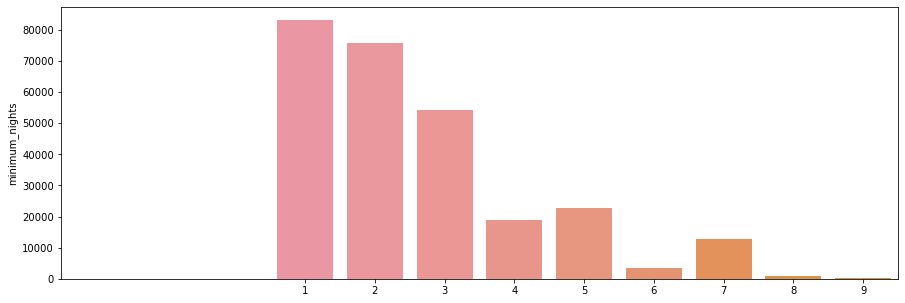

In [25]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_de_barras(base_airbnb['minimum_nights'])

# Aqui tem um motivo talvez até mais forte para excluir esses outliers da análise.
 
# Estou querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

# Por isso, vou excluir os outliers dessa coluna

base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{}, linhas removidas'.format(linhas_removidas))

# Maximum nights

(271885, 22)

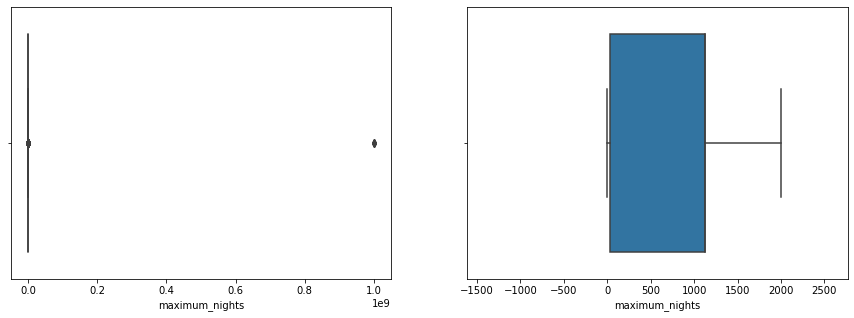

In [26]:
diagrama_caixa(base_airbnb['maximum_nights'])

# Essa coluna não parece que vai ajudar na análise.
# Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(271885, 21)

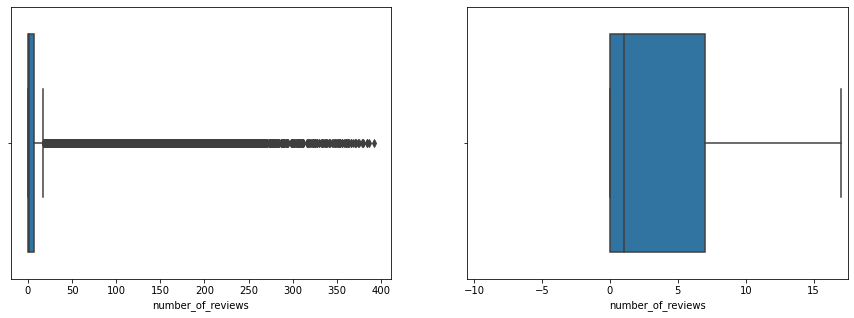

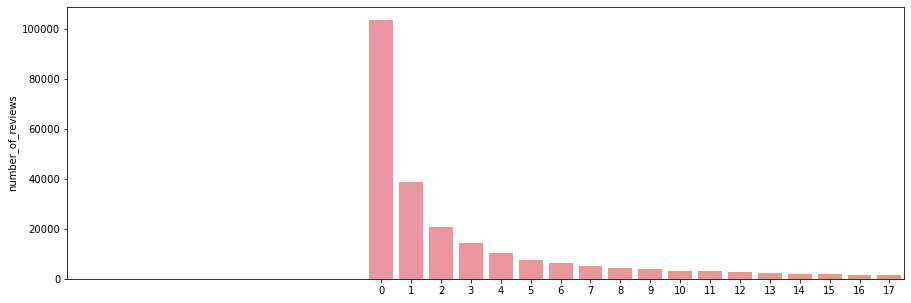

In [21]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_de_barras(base_airbnb['number_of_reviews'])

# Irei remover esta coluna por uma conclusão que cheguei:
#    -  Não acho que o número de reviews possa impactar no preço de uma casa
#    - Acredito também que esta feature pode prejudicar pessoas novatas no site, já que elas provavelmente não terão tantos reviews quanto as grandes mobiliarias, podendo ter seus preços impactados.
#    - Visando tudo isso, resolvi remover essa feature da análise
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

Apartment                 211368
House                      24090
Condominium                14885
Serviced apartment          6115
Loft                        6016
Guest suite                 1872
Bed and breakfast           1333
Guesthouse                  1057
Hostel                       994
Other                        752
Villa                        616
Townhouse                    455
Aparthotel                   294
Tiny house                   292
Earth house                  272
Chalet                       249
Boutique hotel               206
Hotel                        204
Cottage                      146
Casa particular (Cuba)       138
Bungalow                     112
Nature lodge                  73
Cabin                         71
Treehouse                     39
Island                        33
Castle                        30
Boat                          29
Hut                           23
Campsite                      20
Dorm                          20
Camper/RV 

C:\Users\andre\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


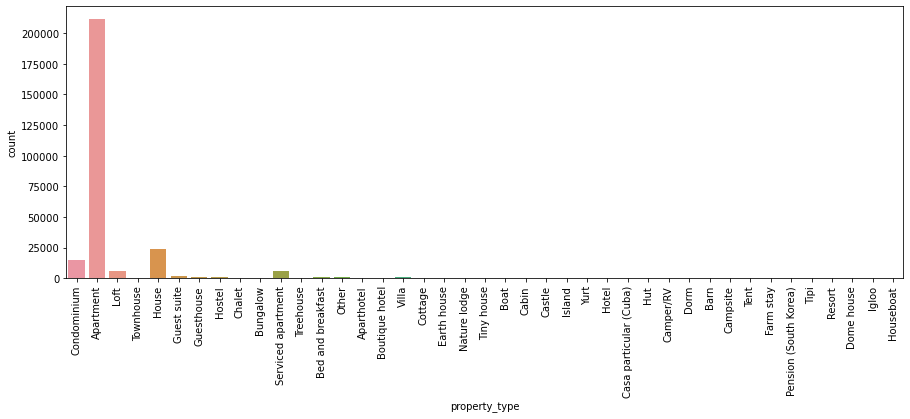

In [27]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)
# - Aqui eu irei colocar os valores que não possuem muita frequência, e junta-los todos em uma mesma coluna de nome 'outros'.
# - Todos os tipos de propriedades que possuem menos frequência na análise menor que 2000, eu irei juntar na nova coluna


['Guest suite', 'Bed and breakfast', 'Guesthouse', 'Hostel', 'Other', 'Villa', 'Townhouse', 'Aparthotel', 'Tiny house', 'Earth house', 'Chalet', 'Boutique hotel', 'Hotel', 'Cottage', 'Casa particular (Cuba)', 'Bungalow', 'Nature lodge', 'Cabin', 'Treehouse', 'Island', 'Castle', 'Boat', 'Hut', 'Campsite', 'Dorm', 'Camper/RV', 'Yurt', 'Barn', 'Pension (South Korea)', 'Tipi', 'Resort', 'Dome house', 'Igloo', 'Farm stay', 'Houseboat', 'Tent']
Apartment             211368
House                  24090
Condominium            14885
Outros                  9411
Serviced apartment      6115
Loft                    6016
Name: property_type, dtype: int64


C:\Users\andre\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


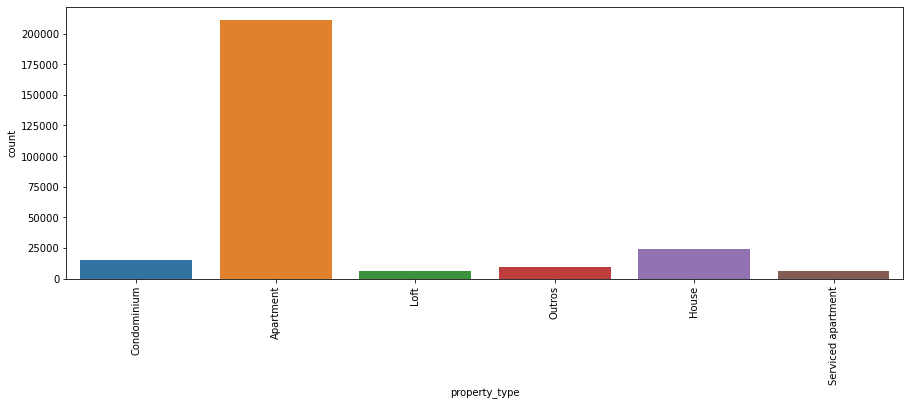

In [28]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2140:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)


# Room Type

Entire home/apt    175528
Private room        90067
Shared room          5487
Hotel room            803
Name: room_type, dtype: int64


C:\Users\andre\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


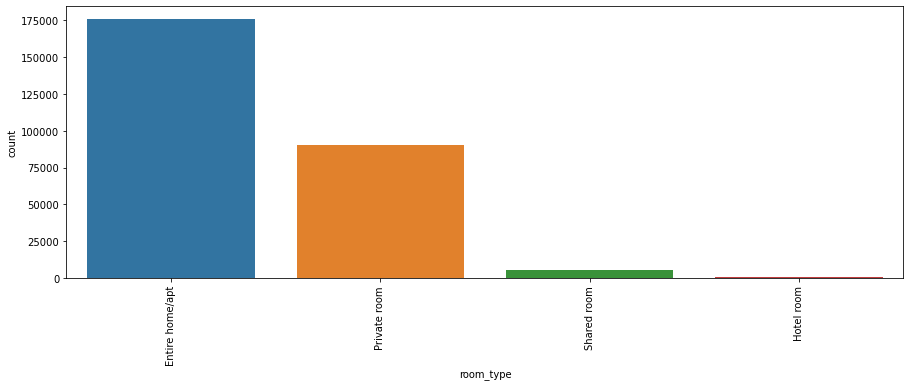

In [29]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)
# Por enquanto, esses dados aparentam estar bem distribuídos, portanto, deixarei como está.

# Bed Type

Real Bed         267100
Pull-out Sofa      3401
Futon               688
Airbed              491
Couch               205
Name: bed_type, dtype: int64
['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed    267100
Outros        4785
Name: bed_type, dtype: int64


C:\Users\andre\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


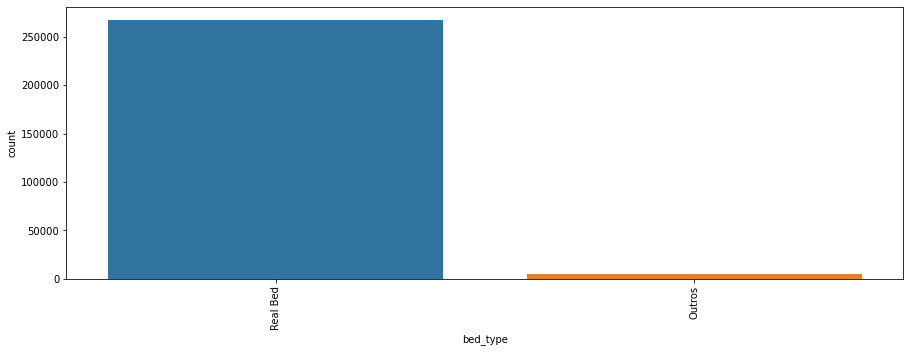

In [30]:
print(base_airbnb['bed_type'].value_counts())

# Agrupando as categorias de bed type
tabela_bed = base_airbnb['bed_type'].value_counts()
agrupar_colunas = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        agrupar_colunas.append(tipo)
print(agrupar_colunas)

for tipo in agrupar_colunas:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'
    
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

# Cancellation policy

flexible                       119480
strict_14_with_grace_period     98723
moderate                        53572
super_strict_60                    83
strict                             16
super_strict_30                    11
Name: cancellation_policy, dtype: int64


C:\Users\andre\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


['super_strict_60', 'strict', 'super_strict_30']
flexible                       119480
strict_14_with_grace_period     98723
moderate                        53572
strict                            110
Name: cancellation_policy, dtype: int64


C:\Users\andre\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


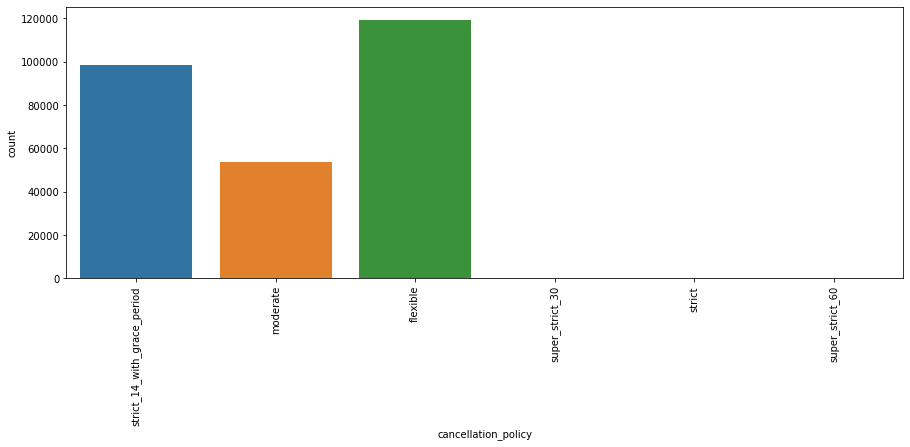

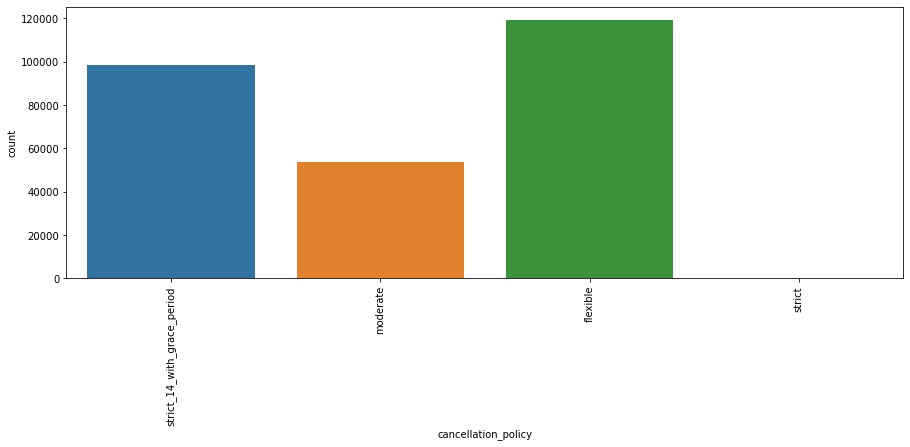

In [31]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#Agrupando categoria de cancellation policy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
agrupar_colunas = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 11000:
        agrupar_colunas.append(tipo)
print(agrupar_colunas)

for tipo in agrupar_colunas:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)


# Amenities
Como no dataset a coluna amenities possui vários valores diferentes, resolvi avaliar a quantidade de amenities como parâmetro para o modelo


In [32]:
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)


['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', 'Heating', 'Washer', 'Dryer', 'Essentials', 'Shampoo', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Dishes and silverware"}']
20


In [33]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(271885, 22)

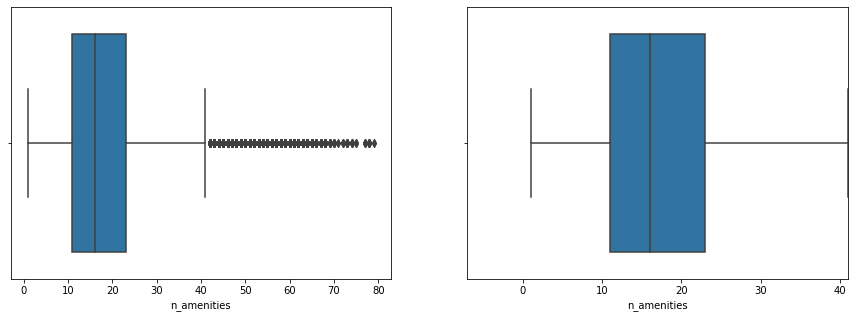

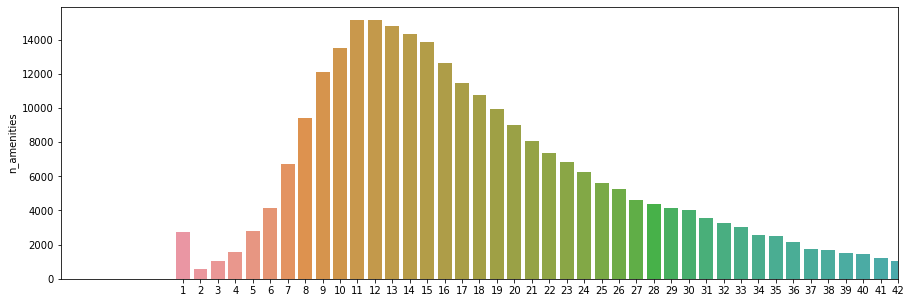

In [29]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_de_barras(base_airbnb['n_amenities'])

# Feito isso, a coluna virou uma coluna numérica, portanto irei excluir esses outliers assim como fiz com as demais colunas de valores numéricos

In [34]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb,'n_amenities')
print('{}, linhas removidas'.format(linhas_removidas))

8850, linhas removidas


# Visualização de Mapa das Propriedades
Irei construir um mapa com uma parcela dos dados (50 000 linhas) para vizualizar a relação entre preço e localização  das casas distribuidas no dataset 


In [38]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius = 2.5,
                        center = centro_mapa, zoom = 10,
                        mapbox_style='stamen-terrain')
mapa.show()

# Encoding
Agora, para ajustar para o modelo, irei ajustar as colunas que possuem valores "True" e "False" e features de categoria(vamos utilizar o método de encoding de variáveis dummies)


In [35]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [36]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias) 
display(base_airbnb_cod.head())

host_is_superhost  host_listings_count  latitude  longitude  accommodates  \
0                 1                  2.0 -22.96592  -43.17896             5   
1                 0                  0.0 -22.98467  -43.19611             6   
2                 0                  3.0 -22.97712  -43.19045             2   
3                 1                  1.0 -22.98302  -43.21427             3   
4                 0                  1.0 -22.98816  -43.19359             2   

   bathrooms  bedrooms  beds  price  guests_included  ...  \
0        1.0       2.0   2.0  218.0                2  ...   
1        2.0       2.0   4.0  422.0                6  ...   
2        1.0       1.0   2.0  158.0                2  ...   
3        1.0       1.0   1.0  342.0                2  ...   
4        1.5       1.0   1.0  479.0                2  ...   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
0                          1                     0                       0   
1                          1                     0                       0   
2                          1                     0                       0   
3                          1                     0                       0   
4                          1                     0                       0   

  room_type_Shared room bed_type_Outros  bed_type_Real Bed  \
0                     0               0                  1   
1                     0               0                  1   
2                     0               0                  1   
3                     0               0                  1   
4                     0               0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
0                           0                                                1  
1                           0                                                1  
2                           0                                                1  
3                           0                                                1  
4                           0                                                1  

[5 rows x 34 columns]

#  Modelos de previsão
 - Irei usar aqui o R² para dizer o quão bem o modelo consegue explicar o preço. 
 - Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando.


In [37]:
def avaliar_modelo (nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RMSE = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'modelo {nome_modelo}: \nR2:{r2:.2%}\nRMSE:{RMSE:.2f}'

# - Modelos que serão testados
  
  1- RandomForest
 
  2- LinearRegression
  

In [38]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()


modelos = {'RandomForest': modelo_rf,
          'LinearRegression':modelo_lr,
          }


y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)


In [43]:
# Separando os dados em treino e teste e o treino dos modelos
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

modelo RandomForest: 
R2:95.33%
RMSE:57.10
modelo LinearRegression: 
R2:32.26%
RMSE:217.56


0
bedrooms                                         0.185627
latitude                                         0.157874
longitude                                        0.154961
extra_people                                     0.095647
n_amenities                                      0.090140
accommodates                                     0.056300
minimum_nights                                   0.053878
bathrooms                                        0.041505
beds                                             0.031107
host_listings_count                              0.028611
instant_bookable                                 0.014798
cancellation_policy_flexible                     0.011523
room_type_Entire home/apt                        0.010620
cancellation_policy_strict_14_with_grace_period  0.009308
property_type_Apartment                          0.008211
cancellation_policy_moderate                     0.007355
room_type_Private room                           0.007173
host_is_superhost                                0.006651
mes                                              0.005636
property_type_Condominium                        0.005110
property_type_House                              0.004216
property_type_Outros                             0.002503
property_type_Loft                               0.002244
ano                                              0.002191
bed_type_Outros                                  0.001673
property_type_Serviced apartment                 0.001665
bed_type_Real Bed                                0.001621
room_type_Shared room                            0.001448
room_type_Hotel room                             0.000289
cancellation_policy_strict                       0.000117
is_business_travel_ready                         0.000000

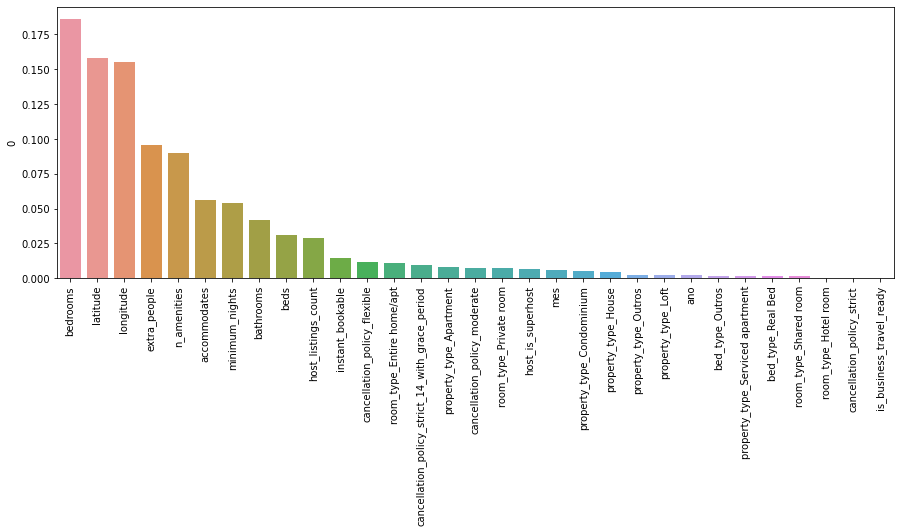

In [44]:
importancia_features = pd.DataFrame(modelo_rf.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)


# Ajustes finais
 De acordo com a análise que fiz acima, percebe-se que a coluna "is_business_travel_ready não possui impacto algum na realização do modelo, por isso a removerei do modelo 


In [39]:
base_airbnb_cod = base_airbnb_cod.drop(columns=['is_business_travel_ready', 'cancellation_policy_strict', 'room_type_Hotel room'])
y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_rf.fit(X_train, y_train)
previsao = modelo_rf.predict(X_test)
print(avaliar_modelo('RandomForest', y_test, previsao))

modelo RandomForest: 
R2:94.79%
RMSE:60.35


In [ ]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:    
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)
y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_rf.fit(X_train, y_train)
previsao = modelo_rf.predict(X_test)
print(avaliar_modelo('RandomForest', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'extra_people', 'minimum_nights', 'instant_bookable',
       'ano', 'mes', 'n_amenities', 'property_type_Apartment',
       'property_type_Condominium', 'property_type_House',
       'property_type_Loft', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')


In [42]:
print(previsao)

[151.07 405.16 216.62 ... 399.13 287.81 295.86]


# Persistindo o modelo para o disco

In [40]:
import joblib 

joblib.dump(modelo_rf, 'previsao.pkl')
# Carregando o modelo a partir da memória
#modelo = joblib.load('previsao.pkl')

['previsao.pkl']